In [ ]:
# Split out test data images
import os
import random
import shutil
from collections import defaultdict

# Paths
image_dir = r'C:\Users\custu\Documents\Report\images'
label_dir = r'C:\Users\custu\Documents\Report\labels'
test_image_dir = r'C:\Users\custu\Documents\Report\test\images'
test_label_dir = r'C:\Users\custu\Documents\Report\test\labels'
train_image_dir = r'C:\Users\custu\Documents\Report\train\images'
train_label_dir = r'C:\Users\custu\Documents\Report\train\labels'

# Ensure folders exist
for path in [test_image_dir, test_label_dir, train_image_dir, train_label_dir]:
    os.makedirs(path, exist_ok=True)

# Target test set
target_test_counts = {
    'center_': 644,
    'edgeloc_': 770,
    'scratch_': 179,
    'donut_': 84,
    'loc_': 539
}

# Group by class
class_files = defaultdict(list)
for file in os.listdir(image_dir):
    if file.endswith('.png') or file.endswith('.jpg'):
        for prefix in target_test_counts:
            if file.startswith(prefix):
                class_files[prefix].append(file)
                break

# Split and move files
for prefix, files in class_files.items():
    random.shuffle(files)
    test_split = files[:target_test_counts[prefix]]
    train_split = files[target_test_counts[prefix]:]

    # Move test files
    for file in test_split:
        base = os.path.splitext(file)[0]
        shutil.copy(os.path.join(image_dir, file), os.path.join(test_image_dir, file))
        shutil.copy(os.path.join(label_dir, base + '.txt'), os.path.join(test_label_dir, base + '.txt'))

    # Move train files
    for file in train_split:
        base = os.path.splitext(file)[0]
        shutil.copy(os.path.join(image_dir, file), os.path.join(train_image_dir, file))
        shutil.copy(os.path.join(label_dir, base + '.txt'), os.path.join(train_label_dir, base + '.txt'))


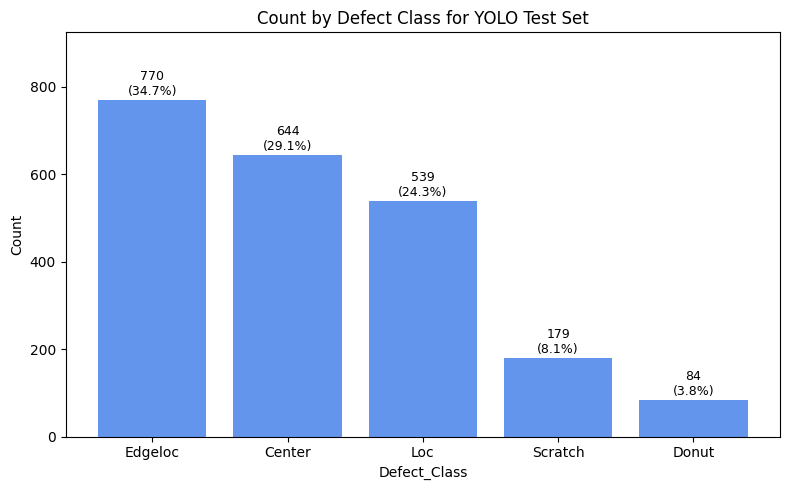

In [21]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Path to test images
test_image_dir = r'C:\Users\custu\Documents\Report\test\images'

# Define class prefixes and readable names
prefix_map = {
    'edgeloc_': 'Edgeloc',
    'center_': 'Center',
    'loc_': 'Loc',
    'scratch_': 'Scratch',
    'donut_': 'Donut'
}

# Count images per class prefix
class_counts = Counter()

for filename in os.listdir(test_image_dir):
    for prefix, class_name in prefix_map.items():
        if filename.startswith(prefix):
            class_counts[class_name] += 1
            break

# Sort for consistent order
classes = list(prefix_map.values())
counts = [class_counts.get(cls, 0) for cls in classes]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, counts, color='cornflowerblue')

# Calculate percentages
total_count = sum(counts)
percentages = [(count / total_count) * 100 for count in counts]

# Add counts and percentages on top of each bar
for bar, count, percentage in zip(bars, counts, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)

# Adjust y-axis limit to provide space for labels
plt.ylim(0, max(counts) * 1.2)

plt.title("Count by Defect Class for YOLO Test Set")
plt.xlabel("Defect_Class")
plt.ylabel("Count")
plt.xticks()
plt.tight_layout()
plt.show()

#### Augmentation of YOLO training data

In [14]:
import os
import cv2
import random
import shutil

# Paths
image_dir = r'C:\Users\custu\Documents\Report\train\images'
label_dir = r'C:\Users\custu\Documents\Report\train\labels'

# Target per-class counts
target_counts = {
    'edgeloc_': 3000,
    'loc_': 3000,
    'scratch_': 2000,
    'donut_': 1200
}

# Rotation angles (in degrees)
angles = [90, 180, 270]

# Get existing class-wise image lists
def get_class_files():
    files_by_class = {cls: [] for cls in target_counts}
    for f in os.listdir(image_dir):
        for cls_prefix in target_counts:
            if f.startswith(cls_prefix) and f.endswith('.png'):
                files_by_class[cls_prefix].append(f)
    return files_by_class

# Rotate YOLO label coordinates (x_center, y_center, width, height)
def rotate_yolo_box(x, y, w, h, angle):
    if angle == 90:
        return 1 - y, x, h, w
    elif angle == 180:
        return 1 - x, 1 - y, w, h
    elif angle == 270:
        return y, 1 - x, h, w
    return x, y, w, h

# Perform augmentation
files_by_class = get_class_files()

for cls_prefix, files in files_by_class.items():
    current_count = len(files)
    needed = target_counts[cls_prefix] - current_count
    if needed <= 0:
        continue

    # Repeat randomly until we reach the target
    while needed > 0:
        src_image = random.choice(files)
        src_base = os.path.splitext(src_image)[0]
        src_img_path = os.path.join(image_dir, src_image)
        src_lbl_path = os.path.join(label_dir, src_base + '.txt')

        if not os.path.exists(src_lbl_path):
            continue

        # Read image
        img = cv2.imread(src_img_path)
        h, w = img.shape[:2]

        # Random rotation
        angle = random.choice(angles)
        rotated_img = None
        if angle == 90:
            rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            rotated_img = cv2.rotate(img, cv2.ROTATE_180)
        elif angle == 270:
            rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Create unique name
        aug_index = random.randint(10000, 99999)
        new_base = f"{cls_prefix}{aug_index}"
        new_img_path = os.path.join(image_dir, new_base + '.png')
        new_lbl_path = os.path.join(label_dir, new_base + '.txt')

        # Prevent overwriting
        if os.path.exists(new_img_path) or os.path.exists(new_lbl_path):
            continue

        # Write image
        cv2.imwrite(new_img_path, rotated_img)

        # Read + rotate labels
        with open(src_lbl_path, 'r') as f:
            new_lines = []
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls, x, y, bw, bh = parts
                    x, y, bw, bh = rotate_yolo_box(float(x), float(y), float(bw), float(bh), angle)
                    new_lines.append(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

        # Save new label file
        with open(new_lbl_path, 'w') as f:
            f.writelines(new_lines)

        needed -= 1

🔁 Augmenting edgeloc_ to add 2368 samples...
🔁 Augmenting loc_ to add 1095 samples...
🔁 Augmenting scratch_ to add 1291 samples...
🔁 Augmenting donut_ to add 729 samples...
✅ Augmentation complete. Training set is now balanced.


### Downsample Center

In [16]:
import os
import random

# Paths
image_dir = r'C:\Users\custu\Documents\Report\train\images'
label_dir = r'C:\Users\custu\Documents\Report\train\labels'

# Desired count
target_count = 3000
prefix = 'center_'

# Collect all center_ image files
center_images = [f for f in os.listdir(image_dir) if f.startswith(prefix) and f.endswith('.png')]

# Safety check
if len(center_images) <= target_count:
    print(f"✅ Already {len(center_images)} or fewer center_ images — no need to downsample.")
else:
    # Randomly select the ones to keep
    keep = set(random.sample(center_images, target_count))

    # Loop through all and delete extras
    deleted = 0
    for filename in center_images:
        if filename not in keep:
            # Delete image
            img_path = os.path.join(image_dir, filename)
            if os.path.exists(img_path):
                os.remove(img_path)

            # Delete corresponding label
            label_file = filename.replace('.png', '.txt')
            label_path = os.path.join(label_dir, label_file)
            if os.path.exists(label_path):
                os.remove(label_path)

            deleted += 1

    print(f"🗑️ Deleted {deleted} center_ images and labels to reduce to {target_count} total.")


🗑️ Deleted 650 center_ images and labels to reduce to 3000 total.


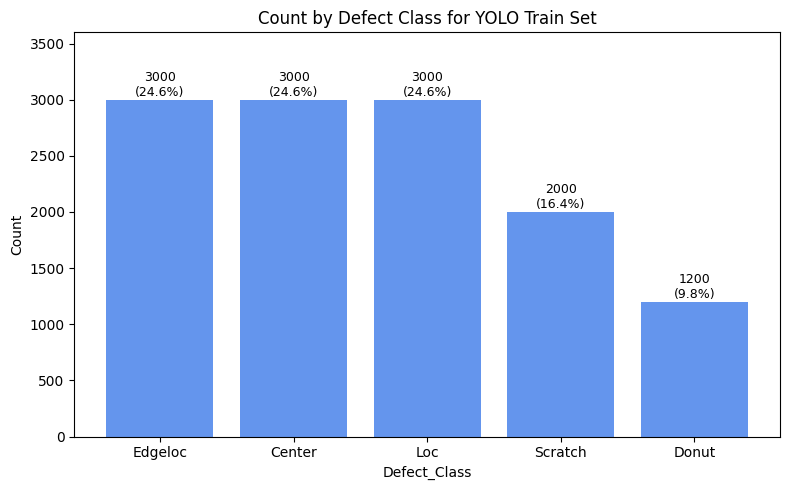

In [19]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Path to test images
test_image_dir = r'C:\Users\custu\Documents\Report\train\images'

# Define class prefixes and readable names
prefix_map = {
    'edgeloc_': 'Edgeloc',
    'center_': 'Center',
    'loc_': 'Loc',
    'scratch_': 'Scratch',
    'donut_': 'Donut'
}

# Count images per class prefix
class_counts = Counter()

for filename in os.listdir(test_image_dir):
    for prefix, class_name in prefix_map.items():
        if filename.startswith(prefix):
            class_counts[class_name] += 1
            break

# Sort for consistent order
classes = list(prefix_map.values())
counts = [class_counts.get(cls, 0) for cls in classes]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, counts, color='cornflowerblue')

# Calculate percentages
total_count = sum(counts)
percentages = [(count / total_count) * 100 for count in counts]

# Add counts and percentages on top of each bar
for bar, count, percentage in zip(bars, counts, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)

# Adjust y-axis limit to provide space for labels
plt.ylim(0, max(counts) * 1.2)

plt.title("Count by Defect Class for YOLO Train Set")
plt.xlabel("Defect_Class")
plt.ylabel("Count")
plt.xticks()
plt.tight_layout()
plt.show()

In [ ]:
# Split out 15% validation set
import os
import random
import shutil
from collections import defaultdict

# Input paths
image_dir = r'C:\Users\custu\Documents\Report\train\images'
label_dir = r'C:\Users\custu\Documents\Report\train\labels'

# Output paths
val_image_dir = r'C:\Users\custu\Documents\Report\val\images'
val_label_dir = r'C:\Users\custu\Documents\Report\val\labels'

# Ensure output folders exist
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Define class prefixes
class_prefixes = ['center_', 'donut_', 'loc_', 'edgeloc_', 'scratch_']
class_files = defaultdict(list)

# Group image files by class prefix
for file in os.listdir(image_dir):
    for prefix in class_prefixes:
        if file.startswith(prefix) and file.endswith('.png'):
            class_files[prefix].append(file)
            break

# Perform 15% stratified split and move to val folder
for prefix, files in class_files.items():
    random.shuffle(files)
    val_count = int(len(files) * 0.15)
    val_files = files[:val_count]

    for img_file in val_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        # Move image
        shutil.move(os.path.join(image_dir, img_file), os.path.join(val_image_dir, img_file))

        # Move corresponding label
        src_label = os.path.join(label_dir, label_file)
        dst_label = os.path.join(val_label_dir, label_file)
        if os.path.exists(src_label):
            shutil.move(src_label, dst_label)



✅ Validation split complete: 15% of each class moved to val set.
